In [1]:
!pip install mne

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import LeaveOneGroupOut

import mne
from mne.datasets.sleep_physionet.age import fetch_data

In [3]:

# classification label target
EVENT_ID = {
    "Sleep stage W": 1,
    "Sleep stage 1/2/3/4": 2,
    "Sleep stage R": 3,
}

# Frequency bands range in Hz for EEG
FREQ_BANDS = {
    "delta": [0.5, 4.5],
    "theta": [4.5, 8.5],
    "alpha": [8.5, 11.5],
    "sigma": [11.5, 15.5],
    "beta": [15.5, 30],
}

# Number of participants used in the analysis
NUM_PARTICIPANT = 10

In [4]:
def load_data(participant_id, event_id=EVENT_ID):
 
  ANNOTATION_EVENT_ID = {
    "Sleep stage W": 1,
    "Sleep stage 1": 2,
    "Sleep stage 2": 2,
    "Sleep stage 3": 2,
    "Sleep stage 4": 2,
    "Sleep stage R": 3,
  }

  # Load two file paths, one for the signal and one for the annotations
  [participant_file] = fetch_data(subjects=[participant_id], recording=[1])

  # Read the signal file with information on each signal
  raw_edf = mne.io.read_raw_edf(
    participant_file[0],
    stim_channel="Event marker",
    infer_types=True,
    preload=True,
    verbose="error"
  )

  # Read the annotation file
  annotation_edf = mne.read_annotations(participant_file[1])

  annotation_edf.crop(annotation_edf[1]["onset"] - 30 * 240, annotation_edf[-2]["onset"] + 30 * 240)

  # Attach the annotation file to the raw edf loaded
  raw_edf.set_annotations(annotation_edf, emit_warning=False)

  # Chunk the data into 30 seconds epochs
  events, _ = mne.events_from_annotations(
      raw_edf, event_id=ANNOTATION_EVENT_ID, chunk_duration=30.0
  )


  # Create the epochs so that we can use it for classification
  tmax = 30.0 - 1.0 / raw_edf.info["sfreq"]  # tmax in included

  epochs = mne.Epochs(
      raw=raw_edf,
      events=events,
      event_id=event_id,
      tmin=0.0,
      tmax=tmax,
      baseline=None,
      preload=True,
  )

  return raw_edf, events, epochs


all_participant_epochs = []
for participant_id in range(NUM_PARTICIPANT):
  _, _, epochs = load_data(participant_id=participant_id)
  all_participant_epochs.append(epochs)

Using default location ~/mne_data for PHYSIONET_SLEEP...
Creating /root/mne_data


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 48.3M/48.3M [00:00<00:00, 98.9GB/s]
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4.62k/4.62k [00:00<00:00, 8.68MB/s]

Download complete in 01m29s (46.1 MB)


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1201 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1201 events and 3000 original time points ...
0 bad epochs dropped
Using default location ~/mne_data for PHYSIONET_SLEEP...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 51.1M/51.1M [00:00<00:00, 107GB/s]
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3.90k/3.90k [00:00<00:00, 7.47MB/s]

Download complete in 01m35s (48.7 MB)


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1463 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1463 events and 3000 original time points ...
0 bad epochs dropped
Using default location ~/mne_data for PHYSIONET_SLEEP...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 51.1M/51.1M [00:00<00:00, 88.2GB/s]
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4.80k/4.80k [00:00<00:00, 8.32MB/s]

Download complete in 01m32s (48.8 MB)


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1385 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1385 events and 3000 original time points ...
0 bad epochs dropped
Using default location ~/mne_data for PHYSIONET_SLEEP...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 51.4M/51.4M [00:00<00:00, 102GB/s]
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3.70k/3.70k [00:00<00:00, 7.31MB/s]

Download complete in 01m31s (49.1 MB)


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1312 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1312 events and 3000 original time points ...
0 bad epochs dropped
Using default location ~/mne_data for PHYSIONET_SLEEP...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 46.9M/46.9M [00:00<00:00, 94.9GB/s]
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4.83k/4.83k [00:00<00:00, 7.56MB/s]

Download complete in 01m22s (44.7 MB)


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1595 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1595 events and 3000 original time points ...
0 bad epochs dropped
Using default location ~/mne_data for PHYSIONET_SLEEP...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 49.7M/49.7M [00:00<00:00, 94.4GB/s]
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3.98k/3.98k [00:00<00:00, 5.96MB/s]

Download complete in 01m27s (47.4 MB)


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1032 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1032 events and 3000 original time points ...
0 bad epochs dropped
Using default location ~/mne_data for PHYSIONET_SLEEP...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 50.5M/50.5M [00:00<00:00, 80.6GB/s]
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 2.62k/2.62k [00:00<00:00, 4.30MB/s]

Download complete in 01m30s (48.2 MB)


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1203 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1203 events and 3000 original time points ...
0 bad epochs dropped
Using default location ~/mne_data for PHYSIONET_SLEEP...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 51.3M/51.3M [00:00<00:00, 109GB/s]
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 3.63k/3.63k [00:00<00:00, 7.23MB/s]

Download complete in 01m29s (48.9 MB)


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1336 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1336 events and 3000 original time points ...
0 bad epochs dropped
Using default location ~/mne_data for PHYSIONET_SLEEP...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 51.0M/51.0M [00:00<00:00, 104GB/s]
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4.31k/4.31k [00:00<00:00, 6.23MB/s]

Download complete in 01m34s (48.6 MB)


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1494 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1494 events and 3000 original time points ...
0 bad epochs dropped
Using default location ~/mne_data for PHYSIONET_SLEEP...


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 49.8M/49.8M [00:00<00:00, 79.4GB/s]
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4.47k/4.47k [00:00<00:00, 7.75MB/s]

Download complete in 01m30s (47.5 MB)


Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']
Not setting metadata
1492 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1492 events and 3000 original time points ...
0 bad epochs dropped


In [7]:
all_participant_epochs

[<Epochs | 1201 events (all good), 0 ‚Äì 29.99 s (baseline off), ~192.4 MiB, data loaded,
  'Sleep stage W': 548
  'Sleep stage 1/2/3/4': 528
  'Sleep stage R': 125>,
 <Epochs | 1463 events (all good), 0 ‚Äì 29.99 s (baseline off), ~234.4 MiB, data loaded,
  'Sleep stage W': 517
  'Sleep stage 1/2/3/4': 776
  'Sleep stage R': 170>,
 <Epochs | 1385 events (all good), 0 ‚Äì 29.99 s (baseline off), ~221.9 MiB, data loaded,
  'Sleep stage W': 488
  'Sleep stage 1/2/3/4': 734
  'Sleep stage R': 163>,
 <Epochs | 1312 events (all good), 0 ‚Äì 29.99 s (baseline off), ~210.2 MiB, data loaded,
  'Sleep stage W': 500
  'Sleep stage 1/2/3/4': 603
  'Sleep stage R': 209>,
 <Epochs | 1595 events (all good), 0 ‚Äì 29.99 s (baseline off), ~255.6 MiB, data loaded,
  'Sleep stage W': 560
  'Sleep stage 1/2/3/4': 839
  'Sleep stage R': 196>,
 <Epochs | 1032 events (all good), 0 ‚Äì 29.99 s (baseline off), ~165.4 MiB, data loaded,
  'Sleep stage W': 568
  'Sleep stage 1/2/3/4': 396
  'Sleep stage R': 68>,

# Feature Calculation

In [5]:
def eeg_power_band(epochs, freq_bands=FREQ_BANDS):
  """Calculate relative spectral analysis on the EEG sensors for each epochs"""

  # Calculate the spectrogram
  spectrum = epochs.compute_psd(picks="eeg", fmin=0.5, fmax=30.0)
  psds, freqs = spectrum.get_data(return_freqs=True)

  # Normalization
  psds /= np.sum(psds, axis=-1, keepdims=True)

  X = []
  # For each frequency band get the mean value and add it to the list X
  for fmin, fmax in freq_bands.values():
    psds_band = psds[:, :, (freqs >= fmin) & (freqs < fmax)].mean(axis=-1)
    X.append(psds_band.reshape(len(psds), -1))

  # return a numpy array, by reshuffling the list from a (5,841,2) to a (841,10)
  return np.concatenate(X, axis=1)

In [6]:

X = []
y = []
groups = []
for group_id, epochs in enumerate(all_participant_epochs):
  print(f"Processing participants #{group_id}")

  X_epoch = eeg_power_band(epochs)
  y_epoch = epochs.events[:, 2]
  group_epoch = [group_id]*len(y_epoch)

  X.append(X_epoch)
  y.append(y_epoch)
  groups.append(group_epoch)

# Transform these lists into numpy array with proper size for sklearn models
X = np.concatenate(X, axis=0)
y = np.concatenate(y, axis=0)
groups = np.concatenate(groups, axis=0)

Processing participants #0
    Using multitaper spectrum estimation with 7 DPSS windows
Processing participants #1
    Using multitaper spectrum estimation with 7 DPSS windows
Processing participants #2
    Using multitaper spectrum estimation with 7 DPSS windows
Processing participants #3
    Using multitaper spectrum estimation with 7 DPSS windows
Processing participants #4
    Using multitaper spectrum estimation with 7 DPSS windows
Processing participants #5
    Using multitaper spectrum estimation with 7 DPSS windows
Processing participants #6
    Using multitaper spectrum estimation with 7 DPSS windows
Processing participants #7
    Using multitaper spectrum estimation with 7 DPSS windows
Processing participants #8
    Using multitaper spectrum estimation with 7 DPSS windows
Processing participants #9
    Using multitaper spectrum estimation with 7 DPSS windows


Testing on participant: #0
Accuracy score: 0.8792672772689425
                     precision    recall  f1-score   support

      Sleep stage W       1.00      0.86      0.92       548
Sleep stage 1/2/3/4       0.86      0.92      0.89       528
      Sleep stage R       0.60      0.78      0.67       125

           accuracy                           0.88      1201
          macro avg       0.82      0.85      0.83      1201
       weighted avg       0.90      0.88      0.88      1201

{'Sleep stage W': 1, 'Sleep stage 1/2/3/4': 2, 'Sleep stage R': 3}
Testing on participant: #1
Accuracy score: 0.885850991114149
                     precision    recall  f1-score   support

      Sleep stage W       0.85      0.99      0.92       517
Sleep stage 1/2/3/4       0.96      0.83      0.89       776
      Sleep stage R       0.74      0.82      0.78       170

           accuracy                           0.89      1463
          macro avg       0.85      0.88      0.86      1463
       weigh

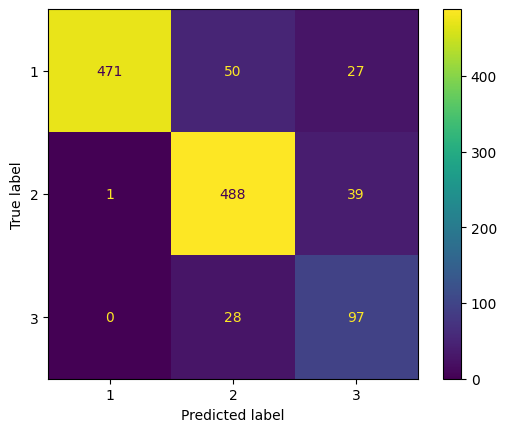

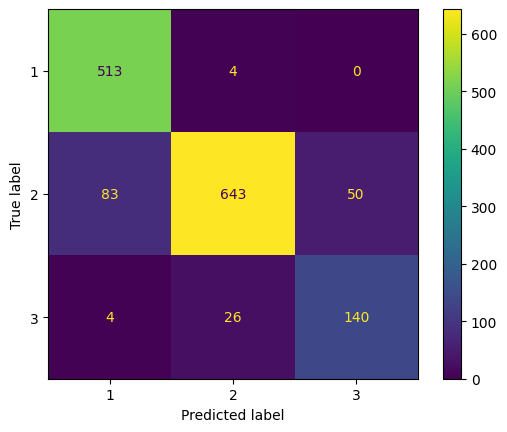

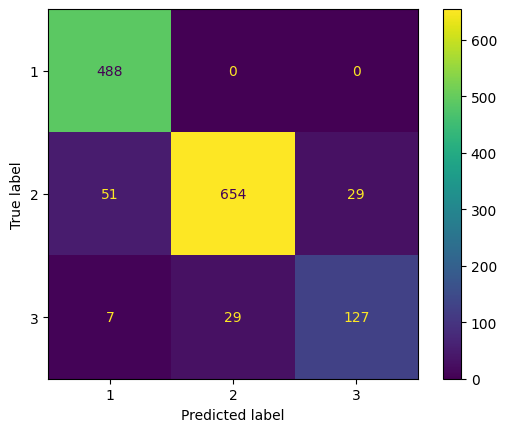

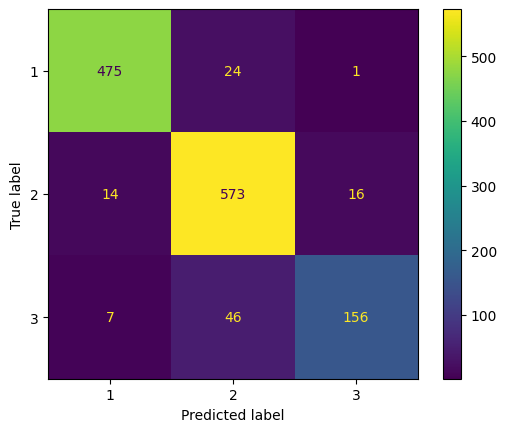

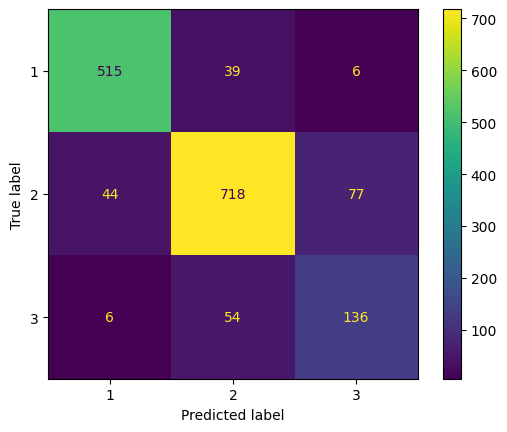

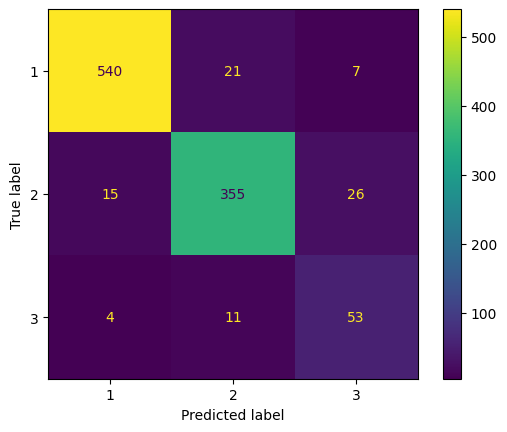

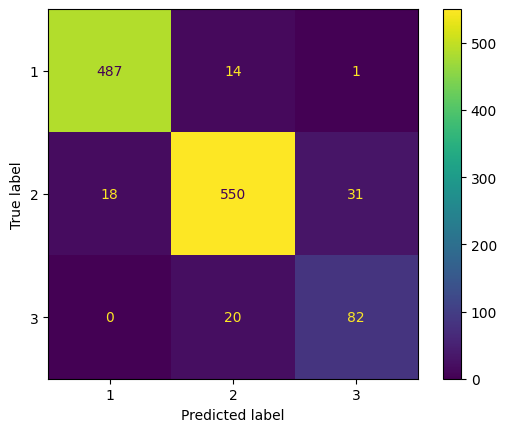

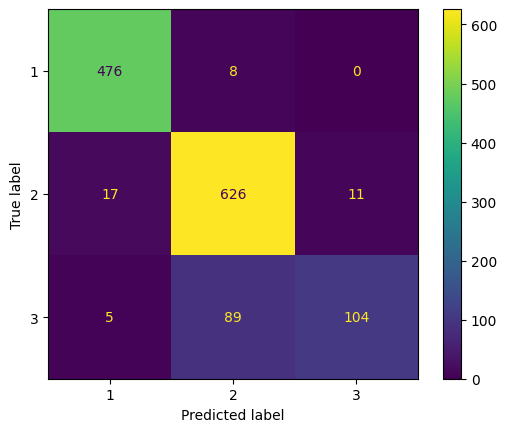

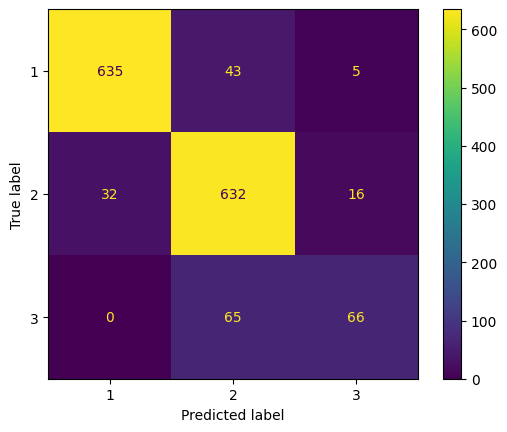

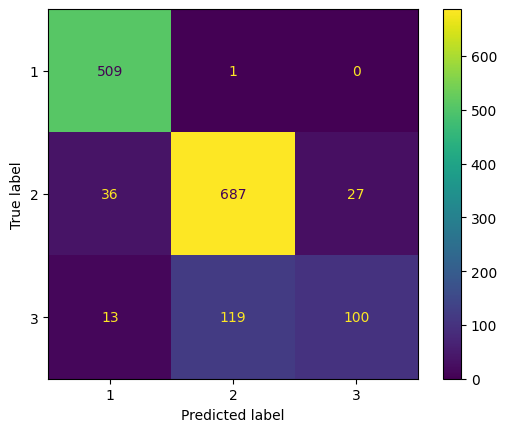

In [8]:
# Leave One Participant Out Cross Validation, using group_id == participant_id
logo = LeaveOneGroupOut()

group_id = 0
for train, test in logo.split(X, y, groups=groups):
  print(f"Testing on participant: #{group_id}")
  group_id = group_id + 1

  # Training of the classifier
  model = RandomForestClassifier(n_estimators=100, random_state=42)
  X_train = X[train]
  y_train = y[train]
  model.fit(X_train, y_train)

  # Testing using the current participant data left out
  X_test = X[test]
  y_test = y[test]
  y_pred = model.predict(X_test)

  acc = accuracy_score(y_test, y_pred)

  print(f"Accuracy score: {acc}")

  # Create a confusion matrix and a report on all the metrics
  cm = confusion_matrix(y_test, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
  disp.plot() # will appear at the end of the output

  print(classification_report(y_test, y_pred, target_names=EVENT_ID.keys()))
  print(EVENT_ID)


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt

models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(kernel="rbf", probability=True),
    "Gradient Boosting": GradientBoostingClassifier()
}

# Store results
results = {name: [] for name in models}



üîç Model: Random Forest


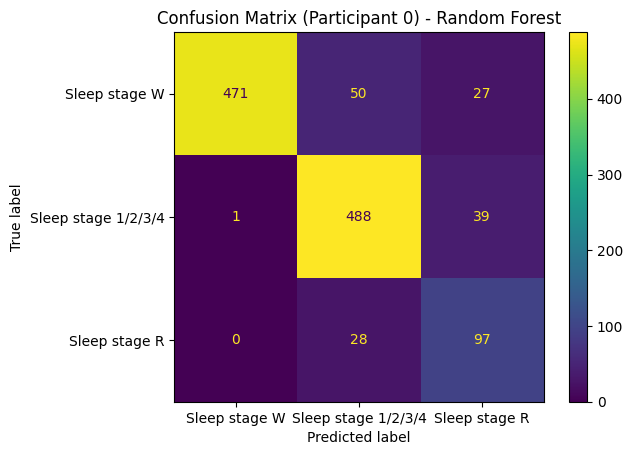


üîç Model: Logistic Regression


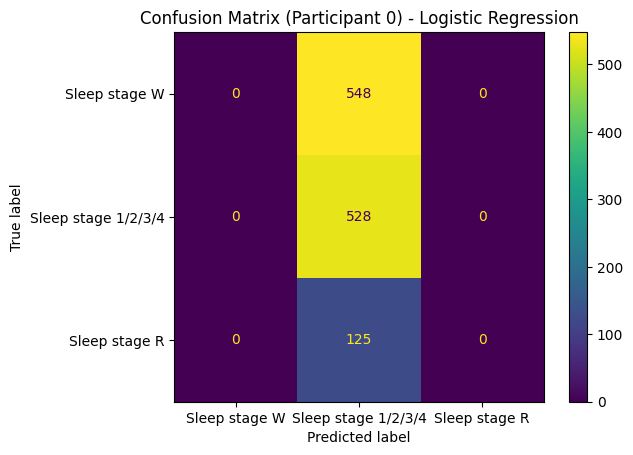


üîç Model: SVM


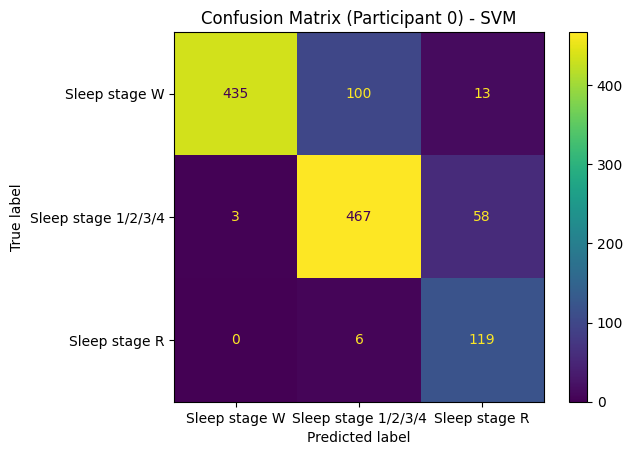


üîç Model: Gradient Boosting


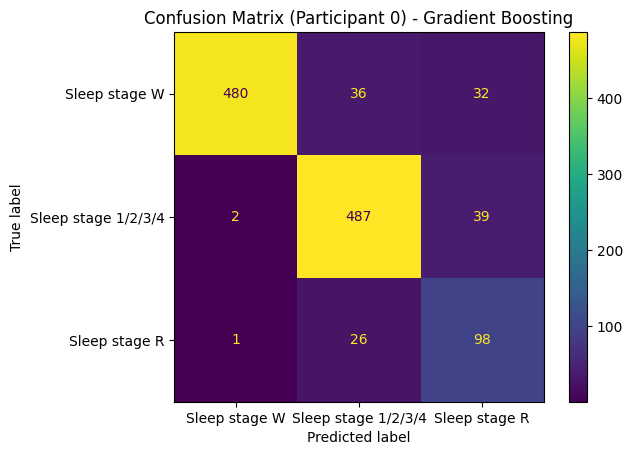

In [10]:
logo = LeaveOneGroupOut()

for model_name, model in models.items():
    print(f"\nüîç Model: {model_name}")
    group_id = 0
    for train, test in logo.split(X, y, groups=groups):
        X_train, y_train = X[train], y[train]
        X_test, y_test = X[test], y[test]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        results[model_name].append(acc)

        if group_id == 0:  # Only plot confusion matrix once per model
            cm = confusion_matrix(y_test, y_pred)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(EVENT_ID.keys()))
            disp.plot()
            plt.title(f"Confusion Matrix (Participant {group_id}) - {model_name}")
            plt.show()

        group_id += 1



üîç Model: Random Forest
Participant #0 - Accuracy: 0.8793


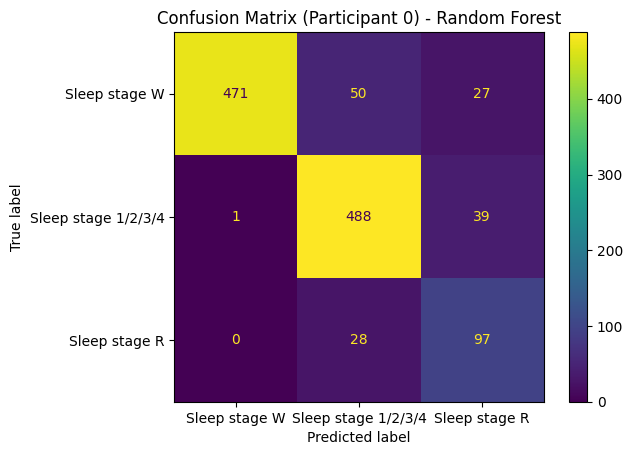

Participant #1 - Accuracy: 0.8859
Participant #2 - Accuracy: 0.9162
Participant #3 - Accuracy: 0.9177
Participant #4 - Accuracy: 0.8583
Participant #5 - Accuracy: 0.9186
Participant #6 - Accuracy: 0.9302
Participant #7 - Accuracy: 0.9027
Participant #8 - Accuracy: 0.8922
Participant #9 - Accuracy: 0.8686

üîç Model: Logistic Regression
Participant #0 - Accuracy: 0.4396


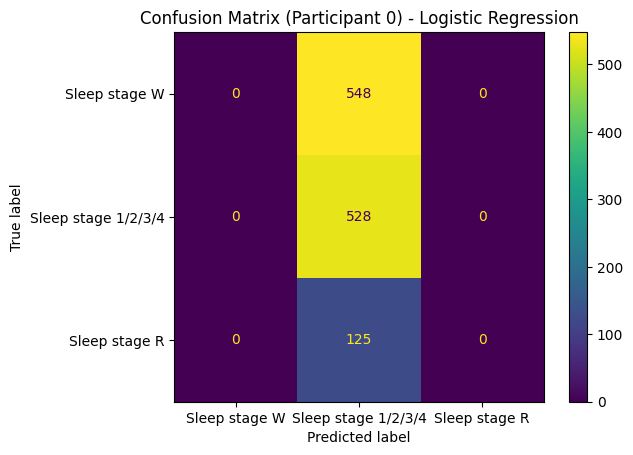

Participant #1 - Accuracy: 0.5304
Participant #2 - Accuracy: 0.5300
Participant #3 - Accuracy: 0.4596
Participant #4 - Accuracy: 0.5260
Participant #5 - Accuracy: 0.3837
Participant #6 - Accuracy: 0.4979
Participant #7 - Accuracy: 0.4895
Participant #8 - Accuracy: 0.4552
Participant #9 - Accuracy: 0.5027

üîç Model: SVM
Participant #0 - Accuracy: 0.8501


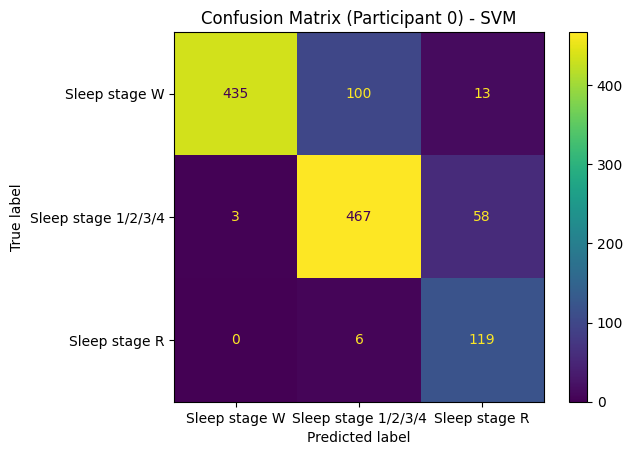

Participant #1 - Accuracy: 0.8742
Participant #2 - Accuracy: 0.8931
Participant #3 - Accuracy: 0.8819
Participant #4 - Accuracy: 0.8445
Participant #5 - Accuracy: 0.8934
Participant #6 - Accuracy: 0.9277
Participant #7 - Accuracy: 0.9034
Participant #8 - Accuracy: 0.9029
Participant #9 - Accuracy: 0.8559

üîç Model: Gradient Boosting
Participant #0 - Accuracy: 0.8868


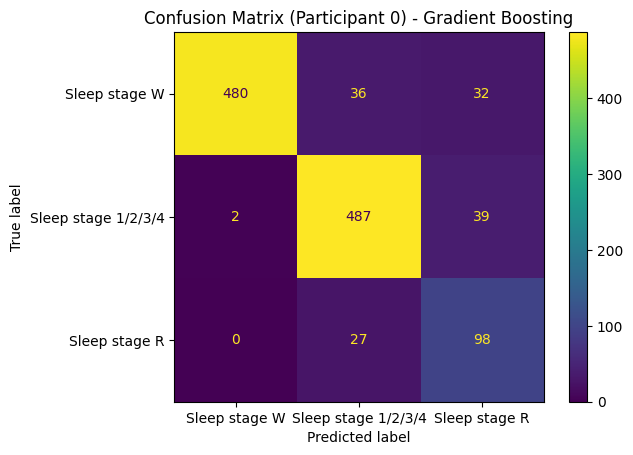

Participant #1 - Accuracy: 0.8763
Participant #2 - Accuracy: 0.9184
Participant #3 - Accuracy: 0.9116
Participant #4 - Accuracy: 0.8583
Participant #5 - Accuracy: 0.9079
Participant #6 - Accuracy: 0.9377
Participant #7 - Accuracy: 0.8922
Participant #8 - Accuracy: 0.8916
Participant #9 - Accuracy: 0.8740

üìä Final Accuracy Summary (Average over all participants):

Random Forest: Mean Accuracy = 0.8970
Logistic Regression: Mean Accuracy = 0.4815
SVM: Mean Accuracy = 0.8827
Gradient Boosting: Mean Accuracy = 0.8955


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Define models
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(kernel="rbf", probability=True),
    "Gradient Boosting": GradientBoostingClassifier()
}

# Store accuracy scores per participant for each model
results = {name: [] for name in models}

logo = LeaveOneGroupOut()

# Loop over each model
for model_name, model in models.items():
    print(f"\nüîç Model: {model_name}")
    group_id = 0

    for train, test in logo.split(X, y, groups=groups):
        X_train, y_train = X[train], y[train]
        X_test, y_test = X[test], y[test]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        results[model_name].append(acc)

        print(f"Participant #{group_id} - Accuracy: {acc:.4f}")

        # Only plot confusion matrix for the first participant
        if group_id == 0:
            cm = confusion_matrix(y_test, y_pred)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(EVENT_ID.keys()))
            disp.plot()
            plt.title(f"Confusion Matrix (Participant {group_id}) - {model_name}")
            plt.show()

        group_id += 1

# --- Final Summary of Results ---

print("\nüìä Final Accuracy Summary (Average over all participants):\n")
for model_name, acc_list in results.items():
    mean_acc = np.mean(acc_list)
    print(f"{model_name}: Mean Accuracy = {mean_acc:.4f}")


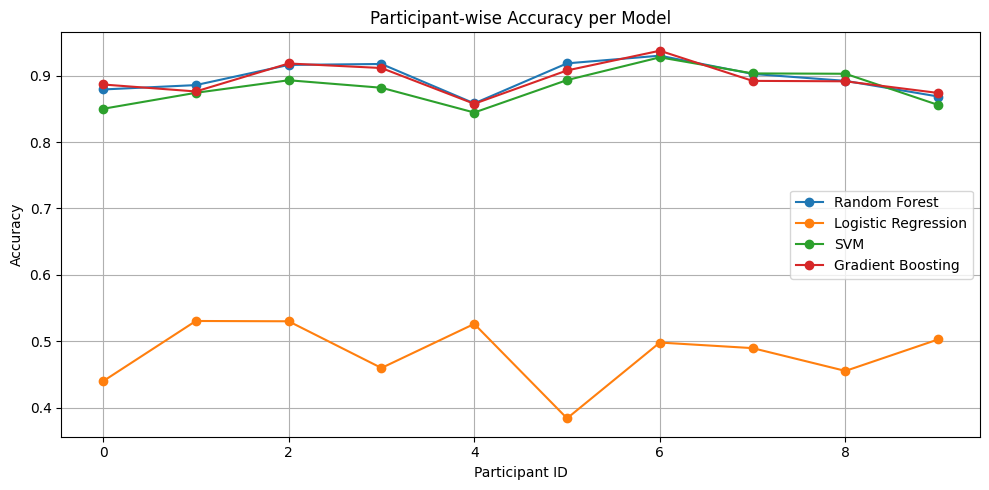

In [11]:
plt.figure(figsize=(10, 5))
for model_name, accs in results.items():
    plt.plot(accs, marker='o', label=model_name)

plt.xlabel("Participant ID")
plt.ylabel("Accuracy")
plt.title("Participant-wise Accuracy per Model")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
